### 1 - Import test data

In [1]:
import pandas as pd
import pandas_ta as ta

df = pd.read_csv("EURUSD_Candlestick_15_M_BID_01.02.2023-17.02.2024.csv")
df["Gmt time"]=df["Gmt time"].str.replace(".000","")
df['Gmt time']=pd.to_datetime(df['Gmt time'],format='%d.%m.%Y %H:%M:%S')
df=df[df.High!=df.Low]
df.set_index("Gmt time", inplace=True)

FileNotFoundError: [Errno 2] No such file or directory: 'EURUSD_Candlestick_5_M_BID_01.02.2023-17.02.2024.csv'

In [ ]:
df["EMA_slow"]=ta.ema(df.Close, length=50)
df["EMA_fast"]=ta.ema(df.Close, length=30)
df['RSI']=ta.rsi(df.Close, length=10)
my_bbands = ta.bbands(df.Close, length=15, std=1.5)
df['ATR']=ta.atr(df.High, df.Low, df.Close, length=7)
df=df.join(my_bbands)
df

,Open,High,Low,Close,Volume,EMA_slow,EMA_fast,RSI,ATR,BBL_15_1.5,BBM_15_1.5,BBU_15_1.5,BBB_15_1.5,BBP_15_1.5
Gmt time,,,,,,,,,,,,,,
2023-02-01 00:00:00,1.08605,1.08616,1.08583,1.08608,771.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-01 00:05:00,1.08608,1.08619,1.08592,1.08594,751.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-01 00:10:00,1.08595,1.08605,1.08588,1.08604,661.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-01 00:15:00,1.08604,1.08609,1.08583,1.08593,1020.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-01 00:20:00,1.08593,1.08623,1.08584,1.08619,563.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-16 21:35:00,1.07771,1.07773,1.07761,1.07766,889.65,1.077578,1.077666,49.870979,0.000153,1.077431,1.077599,1.077768,0.031258,0.680109
2024-02-16 21:40:00,1.07767,1.07772,1.07761,1.07772,551.55,1.077584,1.077670,53.564426,0.000147,1.077431,1.077605,1.077779,0.032320,0.829230
2024-02-16 21:45:00,1.07773,1.07773,1.07760,1.07763,392.25,1.077586,1.077667,47.706198,0.000144,1.077431,1.077605,1.077779,0.032273,0.572845


In [ ]:
# def ema_signal(df, current_candle, backcandles):
#     df_slice = df.reset_index().copy()
#     # Get the range of candles to consider
#     start = max(0, current_candle - backcandles)
#     end = current_candle
#     relevant_rows = df_slice.iloc[start:end]

#     # Check if all EMA_fast values are below EMA_slow values
#     if all(relevant_rows["EMA_fast"] < relevant_rows["EMA_slow"]):
#         return 1
#     elif all(relevant_rows["EMA_fast"] > relevant_rows["EMA_slow"]):
#         return 2
#     else:
#         return 0


# df = df[-40000:-1]
# df.reset_index(inplace=True, drop=True)
# from tqdm import tqdm
# tqdm.pandas()
# df['EMASignal'] = df.progress_apply(lambda row: ema_signal(df, row.name, 7) if row.name >= 20 else 0, axis=1)


#--------------------------------------------------------------------------------------------------------------------
def ema_signal(df, backcandles):
    # Create boolean Series for conditions
    above = df['EMA_fast'] > df['EMA_slow']
    below = df['EMA_fast'] < df['EMA_slow']

    # Rolling window to check if condition is met consistently over the window
    above_all = above.rolling(window=backcandles).apply(lambda x: x.all(), raw=True).fillna(0).astype(bool)
    below_all = below.rolling(window=backcandles).apply(lambda x: x.all(), raw=True).fillna(0).astype(bool)

    # Assign signals based on conditions
    df['EMASignal'] = 0  # Default no signal
    df.loc[above_all, 'EMASignal'] = 2  # Signal 2 where EMA_fast consistently above EMA_slow
    df.loc[below_all, 'EMASignal'] = 1  # Signal 1 where EMA_fast consistently below EMA_slow

    return df

df = df[-60000:]
df.reset_index(inplace=True, drop=True)
df = ema_signal(df,  7)
#--------------------------------------------------------------------------------------------------------------------


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10988\1592871270.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EMASignal'] = 0  # Default no signal


In [ ]:
# def total_signal(df, current_candle, backcandles):
#     if (ema_signal(df, current_candle, backcandles)==2
#         and (df.Open[current_candle]<=df['BBL_15_1.5'][current_candle] or df.Close[current_candle]<=df['BBL_15_1.5'][current_candle])
#         ):
#             return 2
#     if (ema_signal(df, current_candle, backcandles)==1
#         and (df.Open[current_candle]>=df['BBU_15_1.5'][current_candle] or df.Close[current_candle]>=df['BBU_15_1.5'][current_candle])
#         ):
    
#             return 1
#     return 0
        
# df['Total_Signal'] = df.progress_apply(lambda row: total_signal(df, row.name, 7), axis=1)

def total_signal(df):
    # Vectorized conditions for total_signal
    condition_buy = (df['EMASignal'] == 2) & (df['Close'] <= df['BBL_15_1.5'])
    condition_sell = (df['EMASignal'] == 1) & (df['Close'] >= df['BBU_15_1.5'])

    # Assigning signals based on conditions
    df['Total_Signal'] = 0  # Default no signal
    df.loc[condition_buy, 'Total_Signal'] = 2
    df.loc[condition_sell, 'Total_Signal'] = 1

total_signal(df)


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10988\4030472288.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Total_Signal'] = 0  # Default no signal


In [ ]:
import numpy as np
def calculate_rsi_signal_windowed(rsi_series):
    rsi_signal = np.zeros(len(rsi_series))
    for i in range(len(rsi_series)):
        window_start = max(0, i - 5)  # Adjusting to the correct window size
        window = rsi_series[window_start:i]  # Excludes the current value, as intended
        # Apply conditions within the window
        if not window.empty and window.gt(50.1).all():
            rsi_signal[i] = 2
        elif not window.empty and window.lt(49.9).all():
            rsi_signal[i] = 1
        # Else, it remains 0
    return rsi_signal

# Apply the function to calculate RSI_signal
df['RSI_signal'] = calculate_rsi_signal_windowed(df['RSI'])
df['TotalSignal'] = df.apply(lambda row: row['Total_Signal'] if row['Total_Signal'] == row['RSI_signal'] else 0, axis=1)
#df['TotalSignal'] = df["Total_Signal"]

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10988\1076427950.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RSI_signal'] = calculate_rsi_signal_windowed(df['RSI'])
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10988\1076427950.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalSignal'] = df.apply(lambda row: row['Total_Signal'] if row['Total_Signal'] == row['RSI_signal'] else 0, axis=1)


In [ ]:
df.TotalSignal.value_counts()

TotalSignal
0.0    59466
2.0      290
1.0      244
Name: count, dtype: int64

In [ ]:
import numpy as np
def pointpos(x):
    if x['TotalSignal']==2:
        return x['Low']-1e-4
    elif x['TotalSignal']==1:
        return x['High']+1e-4
    else:
        return np.nan

df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10988\4273856290.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
st=100
dfpl = df[st:st+350]
#dfpl.reset_index(inplace=True)
fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close']),

                go.Scatter(x=dfpl.index, y=dfpl['BBL_15_1.5'], 
                           line=dict(color='green', width=1), 
                           name="BBL"),
                go.Scatter(x=dfpl.index, y=dfpl['BBU_15_1.5'], 
                           line=dict(color='green', width=1), 
                           name="BBU"),
                go.Scatter(x=dfpl.index, y=dfpl['EMA_fast'], 
                           line=dict(color='black', width=1), 
                           name="EMA_fast"),
                go.Scatter(x=dfpl.index, y=dfpl['EMA_slow'], 
                           line=dict(color='blue', width=1), 
                           name="EMA_slow")])

fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                marker=dict(size=8, color="MediumPurple"),
                name="entry")
fig.update_layout(width=1200, height=800)
fig.show()

In [ ]:
from backtesting import Strategy
from backtesting import Backtest

dfopt = df[-10000:-5000]
def SIGNAL():
    return dfopt.TotalSignal

class MyStrat(Strategy):
    mysize = 3000
    slcoef = 1.1
    TPSLRatio = 1.5
    
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        slatr = self.slcoef*self.data.ATR[-1]
        TPSLRatio = self.TPSLRatio
       
        if self.signal1==2 and len(self.trades)==0:
            sl1 = self.data.Close[-1] - slatr
            tp1 = self.data.Close[-1] + slatr*TPSLRatio
            self.buy(sl=sl1, tp=tp1, size=self.mysize)
        
        elif self.signal1==1 and len(self.trades)==0:         
            sl1 = self.data.Close[-1] + slatr
            tp1 = self.data.Close[-1] - slatr*TPSLRatio
            self.sell(sl=sl1, tp=tp1, size=self.mysize)

bt = Backtest(dfopt, MyStrat, cash=250, margin=1/30)
stats, heatmap = bt.optimize(slcoef=[i/10 for i in range(10, 26)],
                    TPSLRatio=[i/10 for i in range(10, 26)],
                    maximize='Return [%]', max_tries=300,
                        random_state=0,
                        return_heatmap=True)
stats

f:\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10988\1340352938.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Start                                 50000.0
End                                   54999.0
Duration                               4999.0
Exposure Time [%]                         4.7
Equity Final [$]                    268.85513
Equity Peak [$]                    269.344868
Return [%]                           7.542052
Buy & Hold Return [%]                -0.23472
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -1.962904
Avg. Drawdown [%]                   -0.621981
Max. Drawdown Duration                 1104.0
Avg. Drawdown Duration               223.3125
# Trades                                 53.0
Win Rate [%]                        52.830189
Best Trade [%]                       0.128947
Worst Trade [%]                     -0.052073
Avg. Trade [%]                    

In [ ]:
stats["_strategy"]

<Strategy MyStrat(slcoef=1.1,TPSLRatio=1.1)>

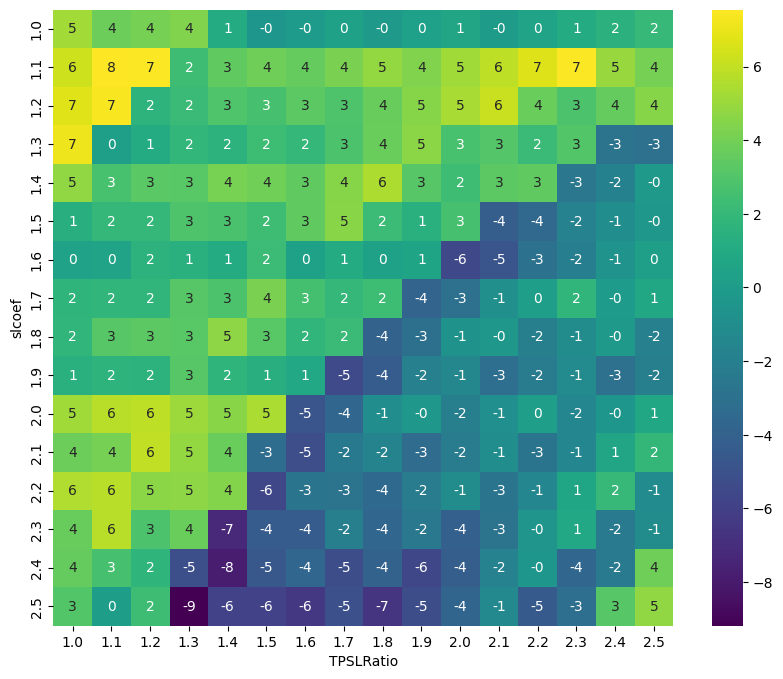

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert multiindex series to dataframe
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.0f')
plt.show()

In [ ]:
from backtesting import Strategy
from backtesting import Backtest

dftest = df[-5000:]
def SIGNAL():
    return dftest.TotalSignal

class MyStrat(Strategy):
    mysize = 3000
    slcoef = 1.1
    TPSLRatio = 1.1
    
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        slatr = self.slcoef*self.data.ATR[-1]
        TPSLRatio = self.TPSLRatio
       
        if self.signal1==2 and len(self.trades)==0:
            sl1 = self.data.Close[-1] - slatr
            tp1 = self.data.Close[-1] + slatr*TPSLRatio
            self.buy(sl=sl1, tp=tp1, size=self.mysize)
        
        elif self.signal1==1 and len(self.trades)==0:         
            sl1 = self.data.Close[-1] + slatr
            tp1 = self.data.Close[-1] - slatr*TPSLRatio
            self.sell(sl=sl1, tp=tp1, size=self.mysize)

bt = Backtest(dftest, MyStrat, cash=250, margin=1/30)
bt.run()

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10988\1121003985.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Start                                 55000.0
End                                   59999.0
Duration                               4999.0
Exposure Time [%]                        8.46
Equity Final [$]                   270.989145
Equity Peak [$]                    275.607896
Return [%]                           8.395658
Buy & Hold Return [%]               -0.952337
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -2.812933
Avg. Drawdown [%]                   -0.494529
Max. Drawdown Duration                 1191.0
Avg. Drawdown Duration             135.181818
# Trades                                 39.0
Win Rate [%]                        61.538462
Best Trade [%]                       0.163463
Worst Trade [%]                     -0.058041
Avg. Trade [%]                    

In [ ]:
bt.plot()

f:\Python\Lib\site-packages\backtesting\_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_drag' property; using the latest value

f:\Python\Lib\site-packages\backtesting\_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_scroll' property; using the latest value



GridPlot(id='p1307', ...)

In [ ]:
class MyStrat(Strategy):
    mysize = 3000
    slcoef = 1.1
    TPSLRatio = 1.1
    
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        slatr = self.slcoef*self.data.ATR[-1]
        TPSLRatio = self.TPSLRatio

        if len(self.trades)==1:
            self.trades[-1].sl = self.trades[-1].entry_price
       
        if self.signal1==2 and len(self.trades)==0:
            sl1 = self.data.Close[-1] - slatr
            tp1 = self.data.Close[-1] + slatr*TPSLRatio
            tp2 = self.data.Close[-1] + slatr*TPSLRatio/2
            #tp2 = tp1 - slatr*TPSLRatio/2
            self.buy(sl=sl1, tp=tp1, size=self.mysize/2)
            self.buy(sl=sl1, tp=tp2, size=self.mysize/2)
        
        elif self.signal1==1 and len(self.trades)==0:         
            sl1 = self.data.Close[-1] + slatr
            tp1 = self.data.Close[-1] - slatr*TPSLRatio
            tp2 = tp1 = self.data.Close[-1] - slatr*TPSLRatio/2
            #tp2 = tp1 + slatr*TPSLRatio/2
            self.sell(sl=sl1, tp=tp1, size=self.mysize/2)
            self.sell(sl=sl1, tp=tp2, size=self.mysize/2)

bt = Backtest(dftest, MyStrat, cash=250, margin=1/30)
bt.run()

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10988\3680219562.py:34: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Start                                 55000.0
End                                   59999.0
Duration                               4999.0
Exposure Time [%]                        3.28
Equity Final [$]                   255.392763
Equity Peak [$]                    261.484906
Return [%]                           2.157105
Buy & Hold Return [%]               -0.952337
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                    -2.37002
Avg. Drawdown [%]                   -0.569993
Max. Drawdown Duration                 1889.0
Avg. Drawdown Duration                 345.25
# Trades                                 80.0
Win Rate [%]                             55.0
Best Trade [%]                       0.080331
Worst Trade [%]                     -0.056951
Avg. Trade [%]                    

In [ ]:
bt.plot()

f:\Python\Lib\site-packages\backtesting\_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_drag' property; using the latest value

f:\Python\Lib\site-packages\backtesting\_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_scroll' property; using the latest value



GridPlot(id='p1638', ...)

# Loop Forward Testing

In [ ]:
from backtesting import Strategy
from backtesting import Backtest

def fit_parameters(df_test):
    def SIGNAL():
        return df_test.TotalSignal
    
    class MyStrat(Strategy):
        mysize = 3000
        slcoef = 1.1
        TPSLRatio = 1.5
        
        def init(self):
            super().init()
            self.signal1 = self.I(SIGNAL)

        def next(self):
            super().next()
            slatr = self.slcoef*self.data.ATR[-1]
            TPSLRatio = self.TPSLRatio
        
            if self.signal1==2 and len(self.trades)==0:
                sl1 = self.data.Close[-1] - slatr
                tp1 = self.data.Close[-1] + slatr*TPSLRatio
                self.buy(sl=sl1, tp=tp1, size=self.mysize)
            
            elif self.signal1==1 and len(self.trades)==0:         
                sl1 = self.data.Close[-1] + slatr
                tp1 = self.data.Close[-1] - slatr*TPSLRatio
                self.sell(sl=sl1, tp=tp1, size=self.mysize)
    
    bt = Backtest(df_test, MyStrat, cash=250, margin=1/30)
    stats, heatmap = bt.optimize(slcoef=[i/10 for i in range(10, 26)],
                        TPSLRatio=[i/10 for i in range(10, 26)],
                        maximize='Return [%]', max_tries=300,
                            random_state=0,
                            return_heatmap=True)

    return (stats["_strategy"].slcoef, stats["_strategy"].TPSLRatio)

In [ ]:
def test_parameters(df, slcoef_in, TPSLRatio_in):
    def SIGNAL():
        return df.TotalSignal

    class MyStrat(Strategy):
        mysize = 3000
        slcoef = slcoef_in
        TPSLRatio = TPSLRatio_in
        
        def init(self):
            super().init()
            self.signal1 = self.I(SIGNAL)

        def next(self):
            super().next()
            slatr = self.slcoef*self.data.ATR[-1]
            TPSLRatio = self.TPSLRatio
        
            if self.signal1==2 and len(self.trades)==0:
                sl1 = self.data.Close[-1] - slatr
                tp1 = self.data.Close[-1] + slatr*TPSLRatio
                self.buy(sl=sl1, tp=tp1, size=self.mysize)
            
            elif self.signal1==1 and len(self.trades)==0:         
                sl1 = self.data.Close[-1] + slatr
                tp1 = self.data.Close[-1] - slatr*TPSLRatio
                self.sell(sl=sl1, tp=tp1, size=self.mysize)

    bt = Backtest(df, MyStrat, cash=250, margin=1/30)
    test_stats = bt.run()
    return test_stats["Return [%]"]

test_parameters(df[-5000:], 1.1, 1.1)


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10988\4044816197.py:29: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



8.395658197603053

In [ ]:
tperiod=int(3000)
half_period = int(tperiod/2)
res = []
for i in range(-60000,-2*tperiod,tperiod):
    print(">>>> i >>>> :", i)
    df_fit = df[i:i+tperiod]
    df_test = df[i+tperiod:i+2*tperiod]
    a, b = fit_parameters(df_fit)
    ret = test_parameters(df_test, a, b)
    res.append(ret)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10988\1230697566.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -60000


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10988\4044816197.py:29: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10988\1230697566.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -55000


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10988\4044816197.py:29: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10988\1230697566.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -50000


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10988\4044816197.py:29: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10988\1230697566.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -45000


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10988\4044816197.py:29: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10988\1230697566.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -40000


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10988\4044816197.py:29: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10988\1230697566.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -35000


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10988\4044816197.py:29: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10988\1230697566.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -30000


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10988\4044816197.py:29: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10988\1230697566.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -25000


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10988\4044816197.py:29: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10988\1230697566.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -20000


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10988\4044816197.py:29: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10988\1230697566.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -15000


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10988\4044816197.py:29: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



In [ ]:
res

[13.78447941591203,
 -6.779522302343264,
 1.9797321808103674,
 -9.039705338250133,
 13.379111010804923,
 -6.1673844158418545,
 3.5728349896586677,
 11.738609513661004,
 14.110526193226042,
 -2.3719518461140976]

In [ ]:
sum(res)


34.20672940152368

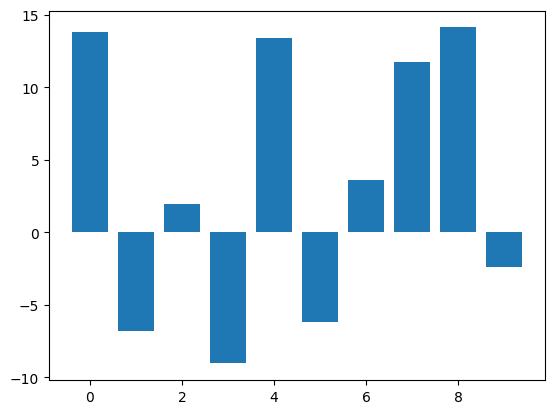

In [ ]:
import matplotlib.pyplot as plt

plt.bar(range(len(res)), res)
plt.show()


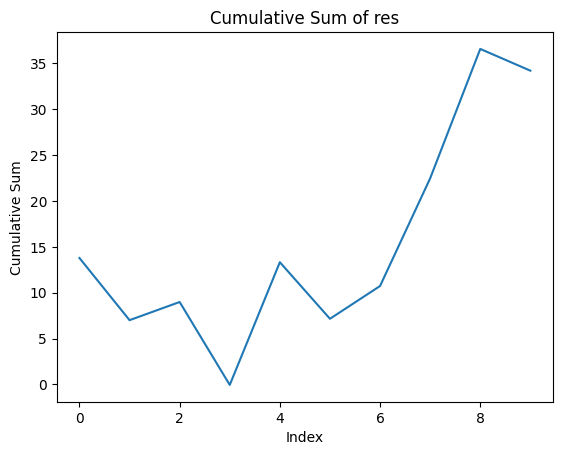

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
res = np.array(res) # Assuming res is already defined
plt.plot(np.cumsum(res))
plt.title("Cumulative Sum of res")
plt.xlabel("Index")
plt.ylabel("Cumulative Sum")
plt.show()
